# WESAD Dataset – Exploratory Data Analysis (EDA)

This notebook explores the **WESAD physiological dataset** for several subjects.  
We inspect the raw sensor streams:

- ECG  
- Temperature (Temp)  
- Electrodermal Activity (EDA)  
- Respiration (Resp)  
- Accelerometer (ACC – X, Y, Z)  

and the associated **label segments** (baseline, stress, amusement, rest).

Raw WESAD files are expected in:

`data/raw/hospital/<subject>/<subject>.pkl`  
(e.g. `data/raw/hospital/S2/S2.pkl`)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

%matplotlib inline

# Adjust this if your path is slightly different
PROJECT_ROOT = Path(r"C:\Users\Admin\OneDrive\Documents\mlopsproject")
RAW_WESAD_DIR = PROJECT_ROOT / "data" / "raw" / "hospitals"

PROJECT_ROOT, RAW_WESAD_DIR


(WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals'))

Listing all available subjects

In [7]:
list(RAW_WESAD_DIR.iterdir())


[WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S10'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S11'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S13'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S14'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S15'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S16'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S17'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S2'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S3'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S4'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents/mlopsproject/data/raw/hospitals/S5'),
 WindowsPath('C:/Users/Admin/OneDrive/Documents

Function to load one subject

In [10]:
def load_wesad_subject(subject_id: str):
    """
    Load the correct WESAD .pkl file only.
    """
    subject_dir = RAW_WESAD_DIR / subject_id

    # Force correct file path
    pkl_path = subject_dir / f"{subject_id}.pkl"

    print("Loading:", pkl_path)

    if not pkl_path.exists():
        raise FileNotFoundError(f"{pkl_path} does not exist — check folder name & spelling.")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    return data


Inspecting sensor keys

In [12]:
data_S2 = load_wesad_subject("S2")
data_S2.keys()


Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S2\S2.pkl


dict_keys(['signal', 'label', 'subject'])

Chest sensors to DataFrame

In [17]:
def chest_to_df(data):
    chest = data["signal"]["chest"]

    def to_1d(x):
        arr = np.asarray(x)
        # flatten anything that is (N,1), (1,N), (N,1,1), etc.
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        return arr

    ecg  = to_1d(chest["ECG"])
    temp = to_1d(chest["Temp"])
    eda  = to_1d(chest["EDA"])
    resp = to_1d(chest["Resp"])

    acc = np.asarray(chest["ACC"])
    # Handle a few possible ACC shapes:
    # (3, N)  -> transpose to (N, 3)
    # (N, 3, 1) or (N, 1, 3) -> flatten last dims to (N, 3)
    if acc.ndim == 2 and acc.shape[0] == 3:
        acc = acc.T
    elif acc.ndim > 2:
        acc = acc.reshape(acc.shape[0], -1)

    if acc.shape[1] < 3:
        raise ValueError(f"ACC has shape {acc.shape}, expected at least 3 columns")

    acc_x = acc[:, 0]
    acc_y = acc[:, 1]
    acc_z = acc[:, 2]

    # Make sure all columns have the same length (take the minimum)
    n = min(len(ecg), len(temp), len(eda), len(resp),
            len(acc_x), len(acc_y), len(acc_z))

    df = pd.DataFrame({
        "ECG":   ecg[:n],
        "Temp":  temp[:n],
        "EDA":   eda[:n],
        "Resp":  resp[:n],
        "ACC_X": acc_x[:n],
        "ACC_Y": acc_y[:n],
        "ACC_Z": acc_z[:n],
    })
    return df


In [18]:
df_chest_S2 = chest_to_df(data_S2)
df_chest_S2.head(), df_chest_S2.shape


(        ECG       Temp       EDA      Resp   ACC_X   ACC_Y   ACC_Z
 0  0.021423  30.120758  5.250549 -1.148987  0.9554 -0.2220 -0.5580
 1  0.020325  30.129517  5.267334 -1.124573  0.9258 -0.2216 -0.5538
 2  0.016525  30.138214  5.243301 -1.152039  0.9082 -0.2196 -0.5392
 3  0.016708  30.129517  5.249405 -1.158142  0.8974 -0.2102 -0.5122
 4  0.011673  30.130951  5.286407 -1.161194  0.8882 -0.2036 -0.4824,
 (4255300, 7))

Basic stats

In [19]:
df_chest_S2.describe().T


,count,mean,std,min,25%,50%,75%,max
ECG,4255300.0,0.001212,0.154077,-1.499542,-0.067978,0.008240,0.044357,1.499313
Temp,4255300.0,30.876677,1.281106,28.045258,30.574951,31.289917,31.815125,34.370392
EDA,4255300.0,1.528387,1.238425,0.263214,0.799561,1.163101,1.546478,7.576752
Resp,4255300.0,0.054906,2.917749,-27.903748,-1.481628,-0.157166,1.618958,27.378845
ACC_X,4255300.0,0.753866,0.175116,0.215000,0.621000,0.856800,0.892200,2.029800
ACC_Y,4255300.0,-0.133188,0.064173,-0.660000,-0.149800,-0.125600,-0.095800,0.539000
ACC_Z,4255300.0,-0.422681,0.300236,-1.135400,-0.717200,-0.322200,-0.209800,1.246800


Raw ECG snippet

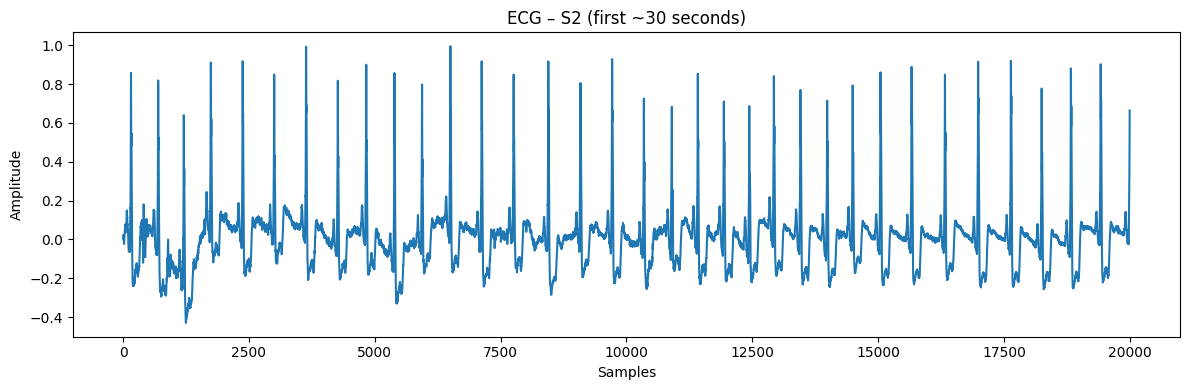

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(df_chest_S2["ECG"][:20000])
plt.title("ECG – S2 (first ~30 seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


Downsample to 1 Hz

In [21]:
# WESAD chest sampling rate is 700 Hz -> take every 700th sample (~1 second)
df_down_S2 = df_chest_S2.iloc[::700].reset_index(drop=True)
df_down_S2.head()


,ECG,Temp,EDA,Resp,ACC_X,ACC_Y,ACC_Z
0,0.021423,30.120758,5.250549,-1.148987,0.9554,-0.2220,-0.5580
1,0.572021,30.101898,5.244446,-0.184631,0.8542,-0.1240,-0.3082
2,-0.124924,30.078644,5.906296,0.103760,0.8682,-0.1362,-0.3170
3,0.069626,30.077240,6.464005,0.129700,0.8594,-0.1282,-0.3218
4,0.057083,30.067047,6.299210,-0.135803,0.8718,-0.1346,-0.3106


Downsampled Temp

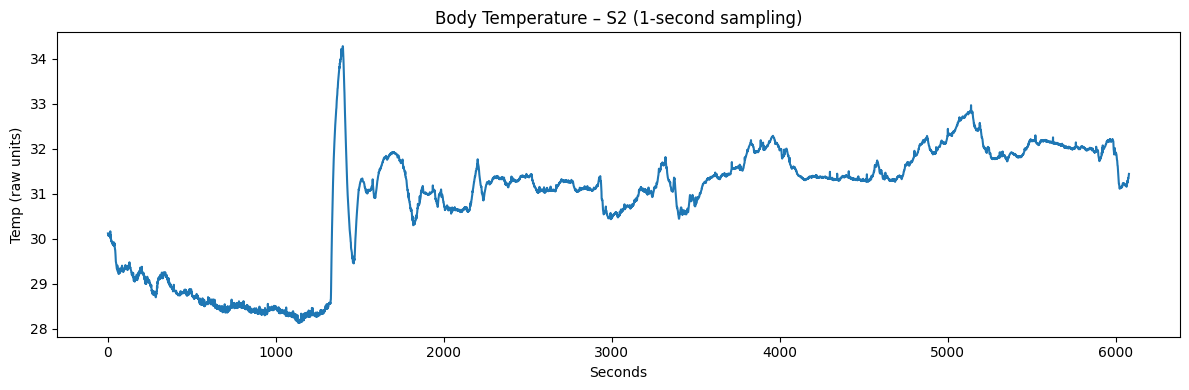

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(df_down_S2["Temp"])
plt.title("Body Temperature – S2 (1-second sampling)")
plt.xlabel("Seconds")
plt.ylabel("Temp (raw units)")
plt.tight_layout()
plt.show()


Downsampled EDA

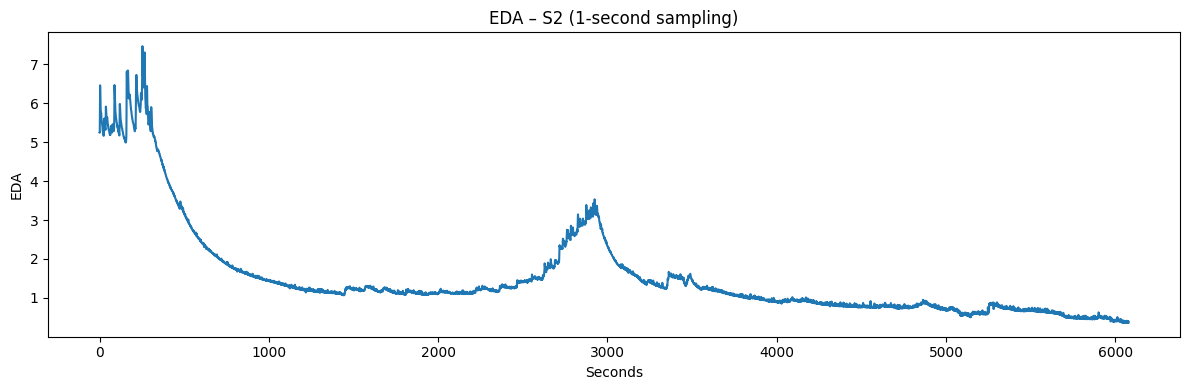

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(df_down_S2["EDA"])
plt.title("EDA – S2 (1-second sampling)")
plt.xlabel("Seconds")
plt.ylabel("EDA")
plt.tight_layout()
plt.show()


Inspect label segments

In [24]:
labels_S2 = data_S2["label"]
labels_S2


array([0, 0, 0, ..., 0, 0, 0], shape=(4255300,), dtype=int32)

Print label ranges

In [28]:
import numpy as np

labels = data_S2["label"]     # your PKL label array

unique_vals = np.unique(labels)

phases = {
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation"
}

for val in unique_vals:
    idx = np.where(labels == val)[0]
    start = idx[0]
    end = idx[-1]
    duration = end - start
    print(f"{phases.get(val,'Unknown'):12s}  start={start:7d}, end={end:7d}, duration={duration:8d} samples")


Unknown       start=      0, end=4255299, duration= 4255299 samples
Baseline      start= 214583, end=1015382, duration=  800799 samples
Stress        start=1591482, end=2021981, duration=  430499 samples
Amusement     start=3334483, end=3587882, duration=  253399 samples
Meditation    start=2868283, end=4111482, duration= 1243199 samples
Unknown       start=2212383, end=2257882, duration=   45499 samples
Unknown       start=3688683, end=3733482, duration=   44799 samples


ECG during stress

Stress segment: 1591482 → 2021981


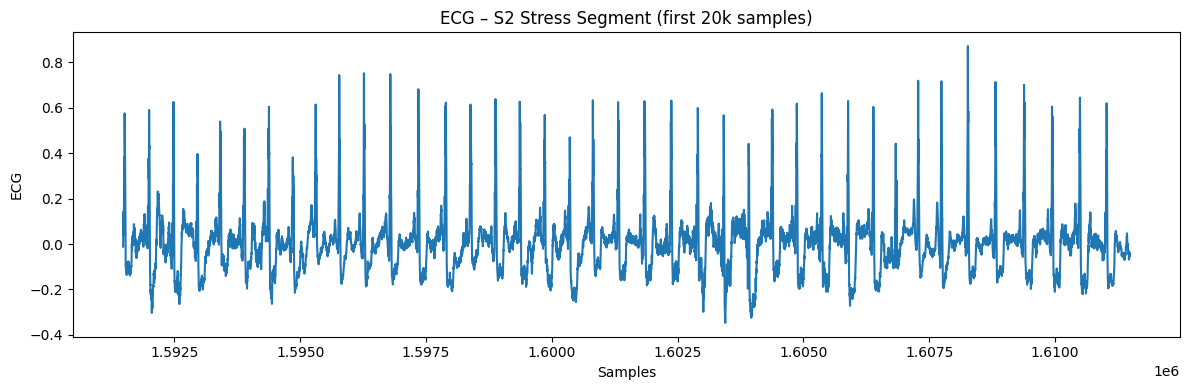

In [30]:
labels = data_S2["label"].astype(int)

# find where label == 2 (stress)
stress_indices = np.where(labels == 2)[0]

if len(stress_indices) == 0:
    raise ValueError("No stress data found in this subject!")

stress_start = stress_indices[0]
stress_end   = stress_indices[-1]

print("Stress segment:", stress_start, "→", stress_end)

plt.figure(figsize=(12,4))

# plot first 20k samples from stress period
plt.plot(df_chest_S2["ECG"][stress_start:stress_start + 20000])

plt.title("ECG – S2 Stress Segment (first 20k samples)")
plt.xlabel("Samples")
plt.ylabel("ECG")
plt.tight_layout()
plt.show()


Baseline vs stress EDA

Baseline: 214583 → 1015382
Stress  : 1591482 → 2021981


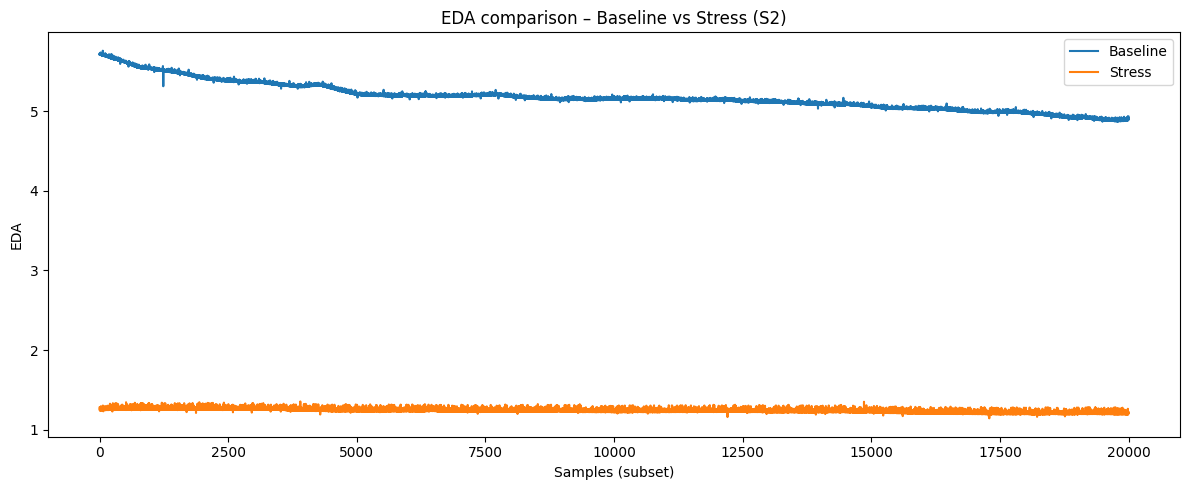

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# labels array (already in your data)
labels = data_S2["label"].astype(int)

# ----- find baseline indices (label == 1) -----
baseline_idx = np.where(labels == 1)[0]
if len(baseline_idx) == 0:
    raise ValueError("No baseline samples (label 1) found for S2")

base_start = baseline_idx[0]
base_end   = baseline_idx[-1]

# ----- find stress indices (label == 2) -----
stress_idx = np.where(labels == 2)[0]
if len(stress_idx) == 0:
    raise ValueError("No stress samples (label 2) found for S2")

stress_start = stress_idx[0]
stress_end   = stress_idx[-1]

print("Baseline:", base_start, "→", base_end)
print("Stress  :", stress_start, "→", stress_end)

# take first 20k samples from each segment for comparison
baseline_eda = df_chest_S2["EDA"].iloc[base_start:base_start + 20_000]
stress_eda   = df_chest_S2["EDA"].iloc[stress_start:stress_start + 20_000]

plt.figure(figsize=(12, 5))
plt.plot(baseline_eda.values, label="Baseline")
plt.plot(stress_eda.values,   label="Stress")
plt.legend()
plt.title("EDA comparison – Baseline vs Stress (S2)")
plt.xlabel("Samples (subset)")
plt.ylabel("EDA")
plt.tight_layout()
plt.show()


Multi-subject length summary

In [33]:
subjects = ["S2", "S3", "S4", "S5", "S9"]
lengths = {}

for sid in subjects:
    data = load_wesad_subject(sid)
    df = chest_to_df(data)
    lengths[sid] = len(df)

lengths


Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S2\S2.pkl
Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S3\S3.pkl
Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S4\S4.pkl
Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S5\S5.pkl
Loading: C:\Users\Admin\OneDrive\Documents\mlopsproject\data\raw\hospitals\S9\S9.pkl


{'S2': 4255300, 'S3': 4545100, 'S4': 4496100, 'S5': 4380600, 'S9': 3656100}

Final summary

## EDA Summary – WESAD

- WESAD provides high-frequency (700 Hz) physiological data from chest and wrist sensors.
- Chest signals include ECG, EDA, Respiration, Temperature, and 3-axis Accelerometer.
- Label segments (baseline, stress, amusement, rest) define different experimental phases.
- Visual inspection shows:
  - ECG and EDA clearly change between baseline and stress.
  - EDA tends to spike during stress.
  - Temperature and respiration show slower trends.
- Because of the extremely high sampling rate, **downsampling** is necessary for:
  - Visualization
  - Matching the slower air-quality data in the federated setup.

These observations support the preprocessing strategy:
- Use chest ECG + Temp as main health features.
- Downsample to 1 value per minute before training.
- Use label segments to build supervised targets (stress vs non-stress).
